In [6]:
from inlifesim.sources import create_localzodi
from inlifesim.util import black_body
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io.votable import parse_single_table
import pandas as pd
from astropy.constants import c as sol
from astropy.constants import h as planck

# 0. What dominates the flux at the aperture?

In [37]:
setup = {
    'wl_min': 4e-6,
    'wl_max': 18e-6,
    'num_wl': 1000,
    'temp_star': 5778,
    'radius_star': 1.,
    'dist_star': 10.,
    'temp_planet': 254,
    'radius_planet': 1.,
    'lat': 0.79,
    'lon': 3 / 4 * np.pi,
    'aperture_size': 3.5,
    'image_size': 256,
    'l_sun': 1,
    'z': 1,
}

wl_bins = np.linspace(setup['wl_min'], setup['wl_max'], setup['num_wl'])
wl_bin_widths = np.diff(wl_bins)
wl_bins = wl_bins[:-1]

In [38]:
def per_micron(input):
    return input.to(u.photon / u.second / (u.meter ** 2) / u.micron)

def create_exozodi(wl_bins: np.ndarray,
                   wl_bin_widths: np.ndarray,
                   l_sun: float,
                   z: float,
                   image_size: int,
                   aperture_diameter: float,
                   dist_star: float,
                   ):
    """
    Creates the exozodiacal dust black body spectrum.

    Parameters
    ----------
    wl_bins : np.ndarray
        The wavelength bins at which the black body is evaluated in [m]
    wl_bin_widths : np.ndarray
        The width of the wavelength bins in [m]
    l_sun : float
        The luminosity of the target star in [stellar luminosity]
    z : float
        The zodi number of the target system in [zodi]
    r_au : np.ndarray
        The radial distance of each pixel to the star in [AU]
    image_size : int
        The size of the image in pixels
    au_pix : np.ndarray
        The conversion factor between [AU] and [pix]
    rad_pix : np.ndarray
        The conversion factor between [rad] and [pix]
    radius_map : np.ndarray
        The radial distance of each pixel to the center of the image in [pix]
    bl : np.ndarray
        The baseline matrix in [m]
    hfov : np.ndarray
        The half field of view of the instrument in [rad]

    Returns
    -------
    b_ez : np.ndarray
        A matrix containing the Bessel function of the exozodi evaluated at the
        baseline matrix and the wavelength bins [ph m-2 s-1]

    """
    
    hfov = wl_bins / (2. * aperture_diameter)

    hfov_mas = hfov * (3600000. * 180.) / np.pi
    rad_pix = (2 * hfov) / image_size  # Radians per pixel
    mas_pix = (2 * hfov_mas) / image_size  # mas per pixel
    au_pix = mas_pix / 1e3 * dist_star  # AU per pixel
    
    x_map = np.tile(np.array(range(0, image_size)),
                        (image_size, 1))
    y_map = x_map.T
    r_square_map = ((x_map - (image_size - 1) / 2) ** 2
                    + (y_map - (image_size - 1) / 2) ** 2)
    radius_map = np.sqrt(r_square_map)
    r_au = (radius_map[np.newaxis, :, :]
                 * au_pix[:, np.newaxis, np.newaxis])
    
    # calculate the parameters required by Kennedy2015
    alpha = 0.34
    r_in = 0.034422617777777775 * np.sqrt(l_sun)
    r_0 = np.sqrt(l_sun)
    # Sigma_{m,0} from Kennedy+2015 (doi:10.1088/0067-0049/216/2/23)
    sigma_zero = 7.11889e-8

    # identify all pixels where the radius is larges than the inner radius by
    # Kennedy+2015
    r_cond = ((r_au >= r_in)
              & (r_au <= image_size / 2 * au_pix[:, np.newaxis, np.newaxis]))

    # calculate the temperature at all pixel positions according to Eq. 2 in
    # Kennedy2015
    temp_map = np.where(r_cond,
                        np.divide(278.3 * (l_sun ** 0.25), np.sqrt(r_au),
                                  out=np.zeros_like(r_au),
                                  where=(r_au != 0.)),
                        0)

    # calculate the Sigma (Eq. 3) in Kennedy2015 and set everything inside the
    # inner radius to 0
    sigma = np.where(r_cond,
                     sigma_zero * z *
                     np.power(r_au / r_in, -alpha,
                              out=np.zeros_like(r_au),
                              where=(r_au != 0.)),
                     0)

    # get the black body radiation emitted by the interexoplanetary dust
    f_nu_disk = black_body(bins=wl_bins[:, np.newaxis, np.newaxis],
                           width=wl_bin_widths[:, np.newaxis, np.newaxis],
                           temp=temp_map,
                           mode='wavelength') \
                * sigma * rad_pix[:, np.newaxis, np.newaxis] ** 2

    flux_exozodi = np.sum(f_nu_disk, axis=(1, 2))

    return flux_exozodi

In [39]:
flux_star = black_body(mode='star',
                       bins=wl_bins,
                       width=wl_bin_widths,
                       temp=setup['temp_star'],
                       radius=setup['radius_star'],
                       distance=setup['dist_star']) / wl_bin_widths * u.photon / u.second / (u.meter ** 3)

flux_star = per_micron(flux_star)

flux_planet = black_body(mode='planet',
                       bins=wl_bins,
                       width=wl_bin_widths,
                       temp=setup['temp_planet'],
                       radius=setup['radius_planet'],
                       distance=setup['dist_star']) / wl_bin_widths * u.photon / u.second / (u.meter ** 3)

flux_planet = per_micron(flux_planet)

flux_localzodi = create_localzodi(wl_bins=wl_bins, 
                                  wl_bin_widths=wl_bin_widths, 
                                  lat=setup['lat'],
                                  long=setup['lon']) / wl_bin_widths * (np.pi * (wl_bins / 2 / setup['aperture_size'])** 2) * u.photon / u.second / (u.meter ** 3)

flux_localzodi = per_micron(flux_localzodi)

flux_exozodi = create_exozodi(wl_bins=wl_bins,
                   wl_bin_widths=wl_bin_widths,
                   l_sun=setup['l_sun'],
                   z=setup['z'],
                   image_size=setup['image_size'],
                   aperture_diameter=setup['aperture_size'],
                   dist_star=setup['dist_star']) / wl_bin_widths * u.photon / u.second / (u.meter ** 3)

flux_exozodi = per_micron(flux_exozodi)

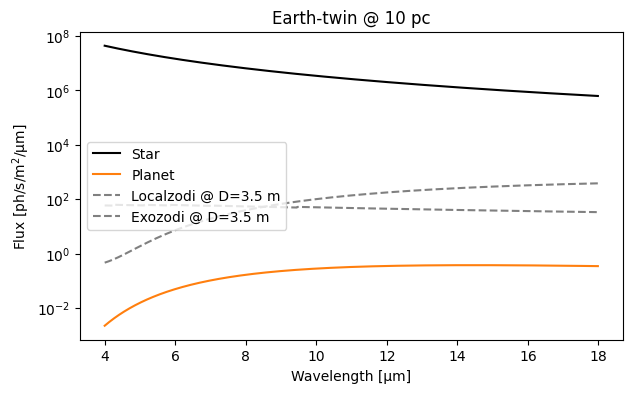

In [48]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(wl_bins * 1e6, flux_star, color='k', label='Star')
plt.plot(wl_bins * 1e6, flux_planet, color='tab:orange', label='Planet')
plt.plot(wl_bins * 1e6, flux_localzodi, color='gray', ls='--', label='Localzodi @ D={} m'.format(setup['aperture_size']))
plt.plot(wl_bins * 1e6, flux_exozodi, color='gray', ls='--', label='Exozodi @ D={} m'.format(setup['aperture_size']))
plt.xlabel('Wavelength [µm]')
plt.ylabel(r'Flux $\mathrm{[ph/s/m^2/\mu m]}$')
plt.yscale('log')
plt.title('Earth-twin @ 10 pc')
plt.legend(loc='center left')
ylim = ax.get_ylim()
fig.savefig('flux_at_aperture.pdf', bbox_inches='tight')
plt.show()

In [52]:
wl_eval = 10e-6

index = np.argmin(np.abs(wl_bins - wl_eval))
print('For Earth-twin at 10 pc at {} µm with {} m apertures:'.format(wl_eval * 1e6, setup['aperture_size']))
print('Star: {:.2e}'.format(flux_star[index]))
print('Planet: {:.2e}'.format(flux_planet[index]))
print('Localzodi: {:.2e}'.format(flux_localzodi[index]))
print('Exozodi: {:.2e}'.format(flux_exozodi[index]))

For Earth-twin at 10 pc at 10.0 µm with 3.5 m apertures:
Star: 3.38e+06 ph / (m2 micron s)
Planet: 2.79e-01 ph / (m2 micron s)
Localzodi: 9.95e+01 ph / (m2 micron s)
Exozodi: 4.98e+01 ph / (m2 micron s)


# 1. Just for star flux

In [27]:
setup = {
    'wl_min': 1e-6,
    'wl_max': 20e-6,
    'num_wl': 1000
}

targets = {'earth_twin': {
    'temp_star': 5778,
    'radius_star': 1,
    'dist_star': 10,
},
    'sirius': {
        'temp_star': 9940,
        'radius_star': 1.71,
        'dist_star': 2.64,
    },
    'm5_star': {
        'temp_star': 3060,
        'radius_star': 0.196,
        'dist_star': 15,
    }
}

wl_bins = np.linspace(setup['wl_min'], setup['wl_max'], setup['num_wl'])
wl_bin_widths = np.diff(wl_bins)
wl_bins = wl_bins[:-1]

In [28]:
def get_star_flux(setup):
    flux_star = black_body(mode='star',
                           bins=wl_bins,
                           width=wl_bin_widths,
                           temp=setup['temp_star'],
                           radius=setup['radius_star'],
                           distance=setup['dist_star']) / wl_bin_widths * u.photon / u.second / (u.meter ** 3)

    flux_star = per_micron(flux_star)
    return flux_star

In [29]:
fluxes = [get_star_flux(targets[target]) for target in targets]

In [30]:
#import vo table under path: /Users/fdannert/Documents/projects/InLIFEsim/working/nice_requirements/thales/vizier_votable.vot
table = parse_single_table('/Users/fdannert/Documents/projects/InLIFEsim/working/nice_requirements/thales/vizier_votable.vot')

# convert to pandas
df = table.to_table().to_pandas()
wl = sol/(np.array(df['sed_freq'])*1e9)*u.second
photon_energy = planck * sol / wl / u.photon

# flux is in Jy
flux = (np.array(df['sed_flux']) * u.Jansky).to(u.Watt / u.meter**2 / u.micron, equivalencies=u.spectral_density(wl))

# flux = (np.array(df['sed_flux']) * u.erg / u.second / u.cm**2 / u.micron).to(u.Watt / u.meter**2 / u.micron)
flux_ph = (flux / photon_energy).to(u.photon / u.second / u.meter**2 / u.micron)

In [31]:
flux_ph.unit

Unit("ph / (m2 micron s)")

In [32]:
sol

<<class 'astropy.constants.codata2018.CODATA2018'> name='Speed of light in vacuum' value=299792458.0 uncertainty=0.0 unit='m / s' reference='CODATA 2018'>

In [33]:
photon_energy.unit

Unit("J / ph")

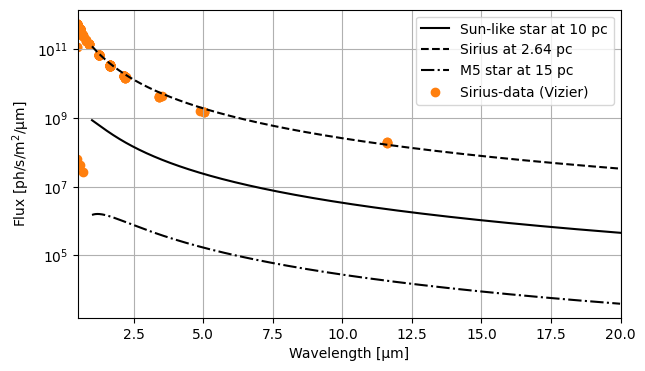

In [36]:
fig, ax = plt.subplots(figsize=(7, 4))

ls = ['-', '--', '-.']
labels = {'earth_twin': 'Sun-like star at 10 pc',
          'sirius': 'Sirius at 2.64 pc',
          'm5_star': 'M5 star at 15 pc'}
for i, target in enumerate(targets):
    plt.plot(wl_bins * 1e6, fluxes[i], label=labels[target], color='k', ls=ls[i])
    
plt.scatter(wl*1e6, flux_ph, label='Sirius-data (Vizier)', color='tab:orange')
plt.xlabel('Wavelength [µm]')
plt.ylabel(r'Flux $\mathrm{[ph/s/m^2/\mu m]}$')
plt.yscale('log')
plt.legend()
plt.grid()
plt.xlim(0.5, 20)
fig.savefig('flux_stars.pdf', bbox_inches='tight')
plt.show()